# GlobAlbedo and associated algorithms

P. Lewis and M. van Leeuwen, UCL/NCEO

This first notebook deals with downloading the data from the database and constructing suitable data structures.

The various forms of (netcdf) inputs are read and the data organised as a set of arrays in set of dictionaries.

These dictionaries are then 'pickled' (saved to disk) for direct use in further processing.

In [1]:
from defaults import *
%matplotlib inline
db = 'http://gws-access.cems.rl.ac.uk/public/globalbedo/.stackXY2/'

data directory /Users/plewis/QA4ECV_ATBD/data


In [2]:
'''
Contact the server for a listing and 
if doit is True download the files and pack into
the dictionary ncfiles. 

Actually, all we really need (to access pre-stored pickle files)
is to set the variable  `datakeys`

Here, we expose the contents of the various datasets (the keys)
'''

doit = False
datakeys = np.array(['bbdr.flags', 'bbdr.meris', 'bbdr.vgt', 'ga.brdf.merge',\
       'ga.brdf.nosnow', 'ga.brdf.snow', 'mod09', 'myd09',\
       'prior.v2.nosnow', 'prior.v2.snow', 'prior.v2.snownosnow'])

if doit:
    # set True if you want to download as well
    ncfiles = obtain_data(db,doit=doit)
    for k in datakeys:
        print '========'
        print k,ncfiles[k].keys()
else:
    ncdata = {}
    for k in datakeys:
        print '========'
        print k,
        ncdata[k] = {}        
        ncdata[k] = load_obj('obj/'+ k + '_s1.0_' )            
        print ncdata[k].keys()
print


bbdr.flags []
bbdr.meris [u'aot_flags', u'BB_NIR', u'BB_VIS', u'Kvol_BRDF_NIR', u'Kgeo_BRDF_VIS', u'sig_BB_NIR_SW', u'RAA', u'SZA', u'Kgeo_BRDF_SW', u'Kgeo_BRDF_NIR', u'Kvol_BRDF_VIS', u'Kvol_BRDF_SW', u'sig_BB_SW_SW', u'cloud_classif_flags', u'VZA', u'sig_BB_NIR_NIR', u'snow_mask', u'BB_SW', 'doy', u'sig_BB_VIS_VIS', u'sig_BB_VIS_SW', u'sig_BB_VIS_NIR']
bbdr.vgt [u'aot_flags', u'BB_NIR', u'BB_VIS', u'Kvol_BRDF_NIR', u'Kgeo_BRDF_VIS', u'sig_BB_NIR_SW', u'RAA', u'SZA', u'Kgeo_BRDF_SW', u'Kgeo_BRDF_NIR', u'Kvol_BRDF_VIS', u'Kvol_BRDF_SW', u'sig_BB_SW_SW', u'cloud_classif_flags', u'VZA', u'sig_BB_NIR_NIR', u'snow_mask', u'BB_SW', 'doy', u'sig_BB_VIS_VIS', u'sig_BB_VIS_SW', u'sig_BB_VIS_NIR']
ga.brdf.merge [u'VAR_NIR_f2_SW_f2', u'VAR_VIS_f0_SW_f2', u'VAR_NIR_f2_SW_f0', u'VAR_NIR_f2_SW_f1', u'VAR_VIS_f2_NIR_f2', u'VAR_VIS_f2_NIR_f1', u'VAR_VIS_f2_NIR_f0', u'VAR_NIR_f0_SW_f0', u'VAR_NIR_f0_SW_f1', u'VAR_NIR_f0_SW_f2', u'VAR_VIS_f0_VIS_f2', u'VAR_VIS_f0_SW_f1', u'VAR_VIS_f0_VIS_f0', u'VAR_VIS

In [3]:
'''
Form the data dictionary (in ncdata), reading and storing each of the
datasets in datakeys.

The only complexities in the code are to do with correcting some variants
(e.g. 'MEAN__BAND________' -> 'MEAN_BAND')

The default parsing splits the key on _1_:

thiskey = kk.split('_1_')[0]

A set of 'special' keys are defined that need to be split / interpreted differently
These are specified in the dictionary specials, with the key name and an integer specifying
how many terms to include.

To decode the TIME field, we look at the keys for
'Cov_NIR_f0_NIR_f0','VAR_NIR_f0_NIR_f0','BB_NIR','MODIS_Grid_1km_2D_Data_Fields_Range'
any one of which can lead to the time field.

'''
if doit:
    print ncfiles
    ncdata = {}

    # the integer specifies how many _ fields to include
    # eg var/covar are functions of band and kernel so 4 variables, so 5
    specials = {
        'Data_Mask_':2,
        'Cov_':5,
        'Mean_':2,
        'VAR_':5,
        'mean_':3,
        'BB_':2,
        'sig_BB_':4,
        'Kgeo_BRDF':3,
        'Kvol_BRDF':3,
        'Kiso_BRDF':3
    }

    for k in datakeys:
        k =  k.strip('/')
        ncdata[k] = {}
        print k
        try:
            ncdata[k] = load_obj('obj/'+ k + '_s1.0_')
        except:
            for i in xrange(len(ncfiles[k])):
                ncfile = Dataset('./' +k+'/'+ncfiles[k][i],'r')         
                for kk in np.sort(ncfile.variables.keys()):
                    # different data keys in different prior versions    
                    # Fix MEAN__BAND________
                    for terms in ['MEAN__BAND________']:
                        thiskey = kk
                        if thiskey[:len(terms)] == terms:
                            thiskey = 'MEAN_BAND_'+thiskey.split(terms)[1:]
                            # eg 0_PARAMETER_F0_0000001_000000

                    # default
                    thiskey = kk.split('_1_')[0]

                    # check if its in the specials
                    for terms in specials.keys():
                        if thiskey[:len(terms)] == terms:
                            thiskey = '_'.join(kk.split('_')[:specials[terms]])

                    # time - specific examples for hooks into time field
                    for terms in ['Cov_NIR_f0_NIR_f0','VAR_NIR_f0_NIR_f0','BB_NIR',\
                                 'MODIS_Grid_1km_2D_Data_Fields_Range']:
                        if thiskey[:len(terms)] == terms:
                            doy = int(kk.split('_')[-2])
                            if ('doy' not in ncdata[k]):
                                print 'TIME'
                                ncdata[k]['doy'] = []
                            ncdata[k]['doy'].append(doy)

                    # other quite special ones, but all of a pattern
                    # e.g. Snow_Fraction_XXX -> Snow_Fraction
                    for terms in ['Snow_Fraction','Goodness_of_Fit','cloud_classif_flags','aot_flags',\
                                 'snow_mask','RAA','SZA','VZA']:
                        # prior
                        nn = terms.count('_') + 1
                        if thiskey[:len(terms)] == terms:
                            thiskey = '_'.join(kk.split('_')[:nn]) 


                    # ignore these ones
                    dontdoit = False
                    for terms in ['Weighted_Number_of_Samples', 'Entropy', 'lat', 'lon',\
                                 'Goodness_of_Fit','Relative_Entropy','Time_to_the_Closest_Sample',\
                                 'AOD550','DEM','NDVI','SM','sig_AOD550','sig_NDVI',\
                                 'Proportion_NSamples','l1_flags',\
                                  'MODIS_Grid_1km_2D_Data_Fields_num_observations_1km',\
                                 'MODIS_Grid_500m_2D_Data_Fields_num_observations_500m']:
                        nn = terms.count('_') + 1
                        if thiskey[:len(terms)] == terms:
                            dontdoit = True
                            thiskey = '_'.join(kk.split('_')[:nn]) 

                    if not dontdoit:
                        if (thiskey not in ncdata[k]):
                            print k,thiskey,";",
                            ncdata[k][thiskey] = []
                        # read the data
                        thisdata = ncfile.variables[kk][:]
                        ncdata[k][thiskey].append(thisdata)
                del ncfile
            save_obj(ncdata[k],'obj/'+k+'_s1.0_')



In [4]:
# sort doys
for k in datakeys:
    print k,
    # prior has doy only
    if k[:5] != 'prior' and ('doy' in ncdata[k].keys()):
        print '\tdate'
        ncdata[k]['date'] = np.atleast_1d(np.zeros(0))
        ncdata[k]['yeardoy'] = np.array([ [int(str(i)[:4]),int(str(i)[4:])] for i in ncdata[k]['doy']])
        for year,doy in ncdata[k]['yeardoy']:
            ncdata[k]['date'] = np.append(ncdata[k]['date'],\
                                          datetime.date(year, 1, 1) + datetime.timedelta(days=doy))
    else:
        print 

bbdr.flags
bbdr.meris 	date
bbdr.vgt 	date
ga.brdf.merge 	date
ga.brdf.nosnow 	date
ga.brdf.snow 	date
mod09 	date
myd09 	date
prior.v2.nosnow
prior.v2.snow
prior.v2.snownosnow


## Modis QA mask

!["https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod09a1"][qatxt]

!["https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod09a1"][qatxt1]

[qatxt]: qa32table.png "https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod09a1"
[qatxt1]: qatable.png "https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod09a1"

In [5]:
# The following keys are available for the MODIS datasets

print ncdata['mod09'].keys()

[u'MODIS_Grid_1km_2D_Data_Fields_SensorZenith', u'MODIS_Grid_500m_2D_Data_Fields_q_scan', u'MODIS_Grid_1km_2D_Data_Fields_SensorAzimuth', 'yeardoy', u'MODIS_Grid_1km_2D_Data_Fields_SolarAzimuth', u'MODIS_Grid_500m_2D_Data_Fields_obscov_500m', u'MODIS_Grid_500m_2D_Data_Fields_iobs_res', u'MODIS_Grid_1km_2D_Data_Fields_SolarZenith', u'MODIS_Grid_1km_2D_Data_Fields_Range', u'MODIS_Grid_1km_2D_Data_Fields_orbit_pnt', u'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b07', u'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b06', u'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b05', u'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b04', u'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b03', u'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b02', u'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b01', u'MODIS_Grid_1km_2D_Data_Fields_state_1km', u'MODIS_Grid_1km_2D_Data_Fields_granule_pnt', 'date', u'MODIS_Grid_1km_2D_Data_Fields_gflags', 'doy', u'MODIS_Grid_500m_2D_Data_Fields_QC_500m']


The MODIS QA mask for this product is specified on the [USGS site](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod09a1).

Here, we will decode `MODIS_Grid_1km_2D_Data_Fields_state_1km`:

In [6]:
qa = ncdata['myd09']['MODIS_Grid_500m_2D_Data_Fields_QC_500m']
qa2 = ncdata['myd09']['MODIS_Grid_1km_2D_Data_Fields_state_1km']
r = ncdata['myd09']['MODIS_Grid_500m_2D_Data_Fields_sur_refl_b01']

# print some info and examples
qa_ = np.array(qa).astype(np.uint32).flatten()
qa2_ = np.array(qa2).astype(np.uint16).flatten()
r_ = np.array(r).astype(np.int16).flatten() * 0.0001

names = ['MODIS_Grid_500m_2D_Data_Fields_QC_500m','MODIS_Grid_1km_2D_Data_Fields_state_1km',\
         'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b01']

for i,v in enumerate([qa,qa2,r]):
    print names[i],type(v),type(v[0]),v[0].dtype,
    for i in xrange(10):
        print v[i][0][0],
    print

for i,v in enumerate([qa_,qa2_,r_]):
    print names[i],type(v),type(v[0]),v[0].dtype,
    for i in xrange(10):
        print v[i],
    print 
    
# The fill value is 4294967295
# so lets see how many of these we have
'''
for i in np.sort(np.array(np.unique(qa2_)).astype(int)):
    print 'There are',(qa2_ == i).sum(),'values with value %d'%i,bin(i)
    print r_[qa2_ == i]
    print '========================'
'''
    
    
# 136?

qcstr = ''
# lets look at the 6 bits that tell us clear, land
bitmask = 2**6-1
for i in np.sort(np.unique(qa2_).astype(np.uint16)):
    m = i & bitmask
    '''
     clear, land (NB - land only!)
     bit 10 : internal cloud algorithm flag  -- trust this
     bit 13 : Pixel is adjacent to cloud -- best not use if possible
     bit 12 : MOD35 snow/ice flag -- exclude snow in this test
     bit 2: cloud shadow - trust this
     bit 15 : internal snow algorithm -- exclude snow in this test
    '''
    if m == 0b001000:
        if not (((i & 2**10)>>10) or ((i & 2**13)>>13) or ((i & 2**12)>>12) \
                or ((i & 2**2)>>2) or ((i & 2**15)>>15)): 
            '''
            print '==========='
            print i,bin(i)
            print '==========='
            for b in xrange(15):
                print b,((i & 2**b)>>b)
            '''
            qcstr += ' ' + str(i)
        
#qcstr = '8 72 136 200 1032 1288 1544 1800 5128 5384 5640 5896 8264 8328 8392 9480 12488 32776 36872 45064'
#qcstr = '8 72 136 200 1288 2056 2120 2184 2248'

print 'valid:',qcstr
# Mixed : 
#

for i in np.sort(np.array(qcstr.split()).astype(np.uint16)):
    print 'There are',(qa2_ == i).sum(),'values with value %d'%i,bin(i)
    print r_[qa2_ == i]
    print '========================'

MODIS_Grid_500m_2D_Data_Fields_QC_500m <type 'list'> <type 'numpy.ndarray'> int32 1073741824 1107296256 1073741824 1107296256 1103101952 1073741824 1073741824 1073741824 1073741824 1073741824
MODIS_Grid_1km_2D_Data_Fields_state_1km <type 'list'> <type 'numpy.ndarray'> int16 8394 1033 1801 1033 72 136 1033 1033 1033 1033
MODIS_Grid_500m_2D_Data_Fields_sur_refl_b01 <type 'list'> <type 'numpy.ndarray'> int16 1118 8505 2309 7914 221 163 7112 3142 7506 9345
MODIS_Grid_500m_2D_Data_Fields_QC_500m <type 'numpy.ndarray'> <type 'numpy.uint32'> uint32 1073741824 1107296256 1073741824 1107296256 1103101952 1073741824 1073741824 1073741824 1073741824 1073741824
MODIS_Grid_1km_2D_Data_Fields_state_1km <type 'numpy.ndarray'> <type 'numpy.uint16'> uint16 8394 1033 1801 1033 72 136 1033 1033 1033 1033
MODIS_Grid_500m_2D_Data_Fields_sur_refl_b01 <type 'numpy.ndarray'> <type 'numpy.float64'> float64 0.1118 0.8505 0.2309 0.7914 0.0221 0.0163 0.7112 0.3142 0.7506 0.9345
valid:  8 72 136 200
There are 8 va

In [7]:
def good_qa(t,good4=[0b001000],bitmask=2**6-1):
    bitmask = 2**6-1
    t = np.uint16(t)
    m = t & bitmask
    if m == 0b001000:
        return True
    
def snow_qa(tt):
    # bit 12 MOD35 snow/ice flag
    # bit 15 internal snow algorithm flag
    tt = np.uint16(np.array(tt))
    s1 = (tt & 2**12)>>12
    s2 = (tt & 2**15)>>15
    snow = np.logical_or(s1,s2)
    return snow

goodqa = np.sort(np.array(qcstr.split()).astype(np.uint16))

def modis_qa(tt,good=goodqa):
    # work on array
    tt = np.uint16(np.array(tt))
    s0 = tt == good[0]
    for g in good[1:]:
        s0 = np.logical_or(s0,tt == g)
    return s0

def modis_qa_broken(tt,good4=[0b001000],bitmask=2**6-1):
    # work on array
    tt = np.uint16(np.array(tt))
    # land no cloud
    s0 = (tt & bitmask) == good4[0]
    '''
     clear, land (NB - land only!)
     bit 10 : internal cloud algorithm flag  -- trust this
     bit 13 : Pixel is adjacent to cloud -- best not use if possible
     bit 12 : MOD35 snow/ice flag -- exclude snow in this test
     bit 2: cloud shadow - trust this
     bit 15 : internal snow algorithm -- exclude snow in this test
    '''    
    for i in [10,13,12,2,15]:
        s0 = np.logical_or(s0,(tt & 2**i)>>i)
    return s0
    
#qcstr = '8 72 136 200 1032 1288 1544 1800 5128 5384 5640 5896 8264 8328 8392 9480 12488 32776 36872 45064'

print qcstr
tt = np.sort(np.array(qcstr.split()).astype(np.uint16))

print 'snow        ',snow_qa(tt)
print 'good        ',modis_qa(tt)
print 'good no snow',np.logical_and(modis_qa(tt),~snow_qa(tt))
print 'good snow   ',np.logical_and(modis_qa(tt),snow_qa(tt))


 8 72 136 200
snow         [False False False False]
good         [ True  True  True  True]
good no snow [ True  True  True  True]
good snow    [False False False False]


## narrow to broadband conversion

We use linear equations of the form:

$$
B = w^T b
$$

where vector $B$ has 3 broad wavebands, $b$ is a vector of the 7 MODIS bands, and $w$ is the weighting matrix.

We also have an uncertainty matrix for the MODIS observations, following Roy et al. (2005) RSE 97: 137-162.

We use the narrow to broadband coefficients of [Liang, 2000](https://www.google.co.uk/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwiOzKrEvYzLAhVBURoKHd7ECxIQFggiMAA&url=http%3A%2F%2Fterpconnect.umd.edu%2F~sliang%2Fpapers%2FRSE.N2B.1.pdf&usg=AFQjCNFDnawdSlcNvMTkNTSdSr447wfbnA&sig2=7SFNU8MS65X9aaVBtv30ow)

In [8]:
# compute modis weights from Roy et al. (2005) RSE 97: 137-162
modissd = np.array([0.004, 0.015, 0.003, 0.004, 0.013, 0.010, 0.006])

RI = np.matrix(np.diag(modissd*modissd)).I

bands = ['VIS','NIR','SW']

# modis narrow to broadband coefficients from Liang, 2000
BBweights = np.array([[0.331,0.000, 0.424,0.246,0.000,0.000,0.000, 0.0000],\
                      [0.039,0.504,-0.071,0.105,0.252,0.069,0.101, 0.0000],\
                      [0.160,0.291, 0.243,0.116,0.112,0.000,0.081,-0.0015]])

print BBweights.sum(axis=1)
# renormalise
BBweights = (BBweights.T / BBweights.sum(axis=1)).T
print BBweights.sum(axis=1)

[ 1.001   0.999   1.0015]
[ 1.  1.  1.]


In [9]:
# form the subset of the weights matrix
H = np.matrix(BBweights[:,:-1]).T

# then the uncertainty (4x4 matrix) is
BBuncertainty_weight = (H.T * RI * H)

In [10]:
# sort MODIS data
for k in ncdata.keys():
    # MODIS processing
    #
    # reflectance observations
    monkey = 'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b%02d'
    monkey1 = monkey%1
    if monkey1 in ncdata[k].keys():
        print k

        modiswt = 1./(modissd*modissd)
        print '\tpotential obs:',k,len(ncdata[k][monkey1])
        ncdata[k]['reflectance'] = np.zeros((7,len(ncdata[k][monkey1])))
        ncdata[k]['weight'] = np.zeros((7,len(ncdata[k][monkey1])))
        for i in xrange(1,8):
            ncdata[k]['reflectance'][i-1,:] = np.array(ncdata[k][monkey%i]).squeeze().astype(float) * 0.0001
            ncdata[k]['weight'][i-1,:] = modiswt[i-1]

                        
        '''
        'snow        ',snow_qa(tt)
        'good        ',modis_qa(tt)
        'good no snow',np.logical_and(modis_qa(tt),~snow_qa(tt))
        'good snow   ',np.logical_and(modis_qa(tt),snow_qa(tt))
        '''
        # extract qa

        # tt1 test gives True when the 2 MODLAND QA bits give 0 
        tt1 = (np.array(ncdata[k]['MODIS_Grid_500m_2D_Data_Fields_QC_500m'])\
              .astype(np.uint32).squeeze() & 3) == 0
        # how many affected?
        print 'pass tt1:',(tt1).sum(),

        # modis_qa(tt) test gives True if the 16 bit field is flagged 'good'
        tt = np.array(ncdata[k]['MODIS_Grid_1km_2D_Data_Fields_state_1km']).squeeze()

        # so modis_qa(tt) AND tt1
        ncdata[k]['mask'] = np.logical_and(tt1,modis_qa(tt))
        print 'pass tt1 and tt:',(ncdata[k]['mask']).sum()

        for c in xrange(ncdata[k]['reflectance'].shape[0]):
            ncdata[k]['reflectance'][c,~ncdata[k]['mask']] = 0.

        # make a mask of zero or -ve reflectabnces
        good =((ncdata[k]['reflectance'] <= 0).sum(axis=0) == 0)    
            
        ncdata[k]['mask'] = np.logical_and(good,ncdata[k]['mask'])
        
        # use this to show that myd gives some bands -ve
        # test this by setting good to 1 everywhere
        print 'r',ncdata[k]['reflectance'][:,(ncdata[k]['mask'])][:,:9]
        #plt.figure()
        #plt.plot()
        
        # apply the linear model to the mean
        BBrefl = (np.dot(BBweights[:,:-1],ncdata[k]['reflectance']).T + BBweights[:,-1]).T
        # narrow to broadband
        ncdata[k]['BB_VIS'] = BBrefl[0]
        ncdata[k]['BB_NIR'] = BBrefl[1]
        ncdata[k]['BB_SW']  = BBrefl[2]

        # uncertainty
        #BBweight = np.dot(BBweights[:,:-1],ncdata[k]['weight'])
        for b1,band1 in enumerate(['VIS','NIR','SW']):
            for b2,band2 in enumerate(['VIS','NIR','SW']):
                if b2 <= b1:
                    term = 'weight_BB_%s_%s'%(band1,band2)
                    ncdata[k][term] = BBuncertainty_weight[b1,b2]


        ncdata[k]['mask_snow'] = np.logical_and(ncdata[k]['mask'],snow_qa(tt))
        ncdata[k]['mask_nosnow'] = np.logical_and(ncdata[k]['mask'],~snow_qa(tt))
        # obscov - use as a weighting term?
        ncdata[k]['obscov'] = 0.01*np.array(ncdata['mod09']['MODIS_Grid_500m_2D_Data_Fields_obscov_500m']).squeeze().astype(float)

        # angles
        vza = 0.01*np.array(ncdata[k]['MODIS_Grid_1km_2D_Data_Fields_SensorZenith']).squeeze().astype(float)
        sza = 0.01*np.array(ncdata[k]['MODIS_Grid_1km_2D_Data_Fields_SolarZenith']).squeeze().astype(float)
        vaa = 0.01*np.array(ncdata[k]['MODIS_Grid_1km_2D_Data_Fields_SensorAzimuth']).squeeze().astype(float)
        saa = 0.01*np.array(ncdata[k]['MODIS_Grid_1km_2D_Data_Fields_SolarAzimuth']).squeeze().astype(float)
        kern = kernels.Kernels(vza, sza, vaa-saa, doIntegrals=False, RossHS=False, RossType='Thick',\
                 LiType='Sparse', normalise=1, nbar=0., RecipFlag=True, MODISSPARSE=True)

        ncdata[k]['Kvol'],ncdata[k]['Kgeo'] = np.asarray(kern.Ross),np.asarray(kern.Li)



mod09
	potential obs: mod09 5727
pass tt1: 5572 pass tt1 and tt: 722
r [[ 0.0357  0.0555  0.0486  0.0446  0.0508  0.0469  0.0404  0.056   0.049 ]
 [ 0.1135  0.1689  0.1353  0.1227  0.1403  0.1593  0.1497  0.1909  0.1962]
 [ 0.0171  0.0285  0.0248  0.0228  0.0232  0.0231  0.0194  0.0195  0.0259]
 [ 0.0287  0.0489  0.0398  0.0385  0.042   0.0414  0.0369  0.0495  0.0507]
 [ 0.1624  0.2316  0.1925  0.1715  0.1922  0.2186  0.1963  0.2536  0.2346]
 [ 0.1229  0.1892  0.1623  0.1423  0.167   0.1798  0.1609  0.1983  0.1817]
 [ 0.143   0.1131  0.0993  0.0851  0.1445  0.1083  0.117   0.1784  0.0994]]
myd09
	potential obs: myd09 4916
pass tt1: 4793 pass tt1 and tt: 576
r [[ 0.0221  0.0163  0.0166  0.0218  0.0206  0.0316  0.032   0.0178  0.0478]
 [ 0.4122  0.3301  0.403   0.3954  0.3459  0.2978  0.2566  0.2837  0.3174]
 [ 0.0123  0.0087  0.0042  0.0114  0.0123  0.0153  0.0184  0.0098  0.018 ]
 [ 0.0391  0.0289  0.0322  0.0358  0.0341  0.0406  0.0387  0.0294  0.0493]
 [ 0.3699  0.2797  0.3629  0.360

In [11]:
k = 'myd09'
((ncdata[k]['reflectance'] <= 0).sum(axis=0) == 0).shape

(4916,)

## Examine MODIS data

We can now examine the MODIS broad band reflectance data.

We can look in particular at whether the two formulae given by Liang for direct and diffuse effects make any real difference.

We can also examine the quality and quantity of snow and no snow data:

0.00572187581121
0.0177156328726
0.0102030218372
0.00572187581121
0.0177156328726
0.0102030218372
0.00572187581121
0.0177156328726
0.0102030218372
0.00572187581121
0.0177156328726
0.0102030218372


(0, 0.059999999999999998)

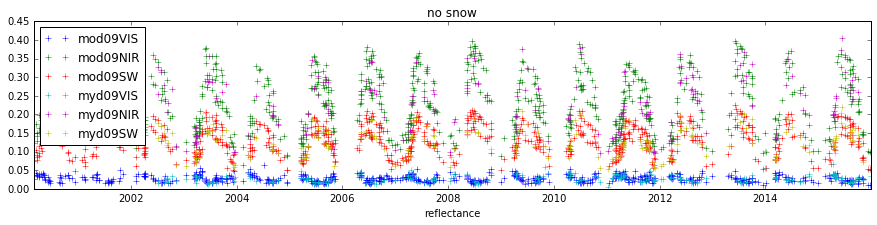

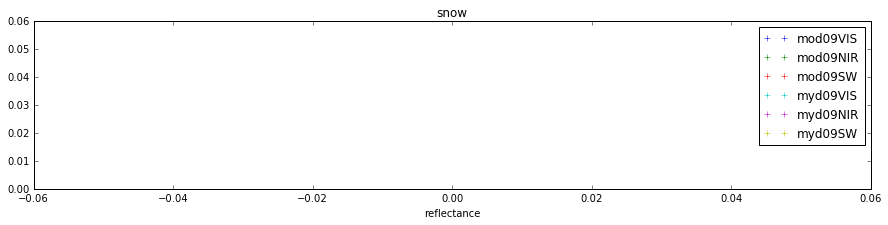

In [12]:
bands = ['VIS','NIR','SW']

plt.figure(figsize=(15,3))
for mod in ['mod09','myd09']:
    for i in xrange(3):
        mm = ncdata[mod]['mask_nosnow']
        x = ncdata[mod]['date'][mm]
        y = ncdata[mod]['BB_%s'%bands[i]][mm]
        w = ncdata[mod]['weight_BB_%s_%s'%(bands[i],bands[i])]
        unc =  np.sqrt(1/w)
        print unc
        plt.plot(x,y,'+',label=mod+bands[i])
plt.xlabel('time')
plt.xlabel('reflectance')
plt.legend(loc='best')
plt.title('no snow')
plt.ylim(0,None)

plt.figure(figsize=(15,3))
for mod in ['mod09','myd09']:
    for i in xrange(3):
        mm = ncdata[mod]['mask_snow']
        x = ncdata[mod]['date'][mm]
        y = ncdata[mod]['BB_%s'%bands[i]][mm]
        w = ncdata[mod]['weight_BB_%s_%s'%(bands[i],bands[i])]
        unc =  np.sqrt(1/w)
        print unc
        plt.plot(x,y,'+',label=mod+bands[i])
plt.xlabel('time')
plt.xlabel('reflectance')
plt.legend(loc='best')
plt.title('snow')
plt.ylim(0,None)

In [13]:
# save objects
for k in datakeys:
    print k
    try:
        save_obj(ncdata[k],'obj/'+k+'_s2.0_')
    except:
        pass

bbdr.flags
bbdr.meris
bbdr.vgt
ga.brdf.merge
ga.brdf.nosnow
ga.brdf.snow
mod09
myd09
prior.v2.nosnow
prior.v2.snow
prior.v2.snownosnow
